**This notebook is an exercise in the [Introduction to Machine Learning](https://www.kaggle.com/learn/intro-to-machine-learning) course.  You can reference the tutorial at [this link](https://www.kaggle.com/alexisbcook/machine-learning-competitions).**

---


# ****Introduction

In this exercise, you will create and submit predictions for a Kaggle competition. You can then improve your model (e.g. by adding features) to apply what you've learned and move up the leaderboard.

Begin by running the code cell below to set up code checking and the filepaths for the dataset.

In [346]:
# Import helpful libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, f_oneway
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.datasets import load_breast_cancer
from hyperopt import fmin, tpe, hp, Trials
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Load the data, and separate the target
train_data_path = '../input/train.csv'
train_data = pd.read_csv(iowa_file_path)
train_data = train_data.dropna(subset=['SalePrice'])
train_data.reset_index(drop=True, inplace=True)
train_data = train_data.drop(columns=['Id'])
y_train = pd.DataFrame(train_data.SalePrice)
X_train = train_data.drop('SalePrice', axis=1)

# path to file you will use for predictions
test_data_path = '../input/test.csv'
test_data = pd.read_csv(test_data_path)
test_data.reset_index(drop=True, inplace=True)
test_data = test_data.drop(columns=['Id'])

## Target

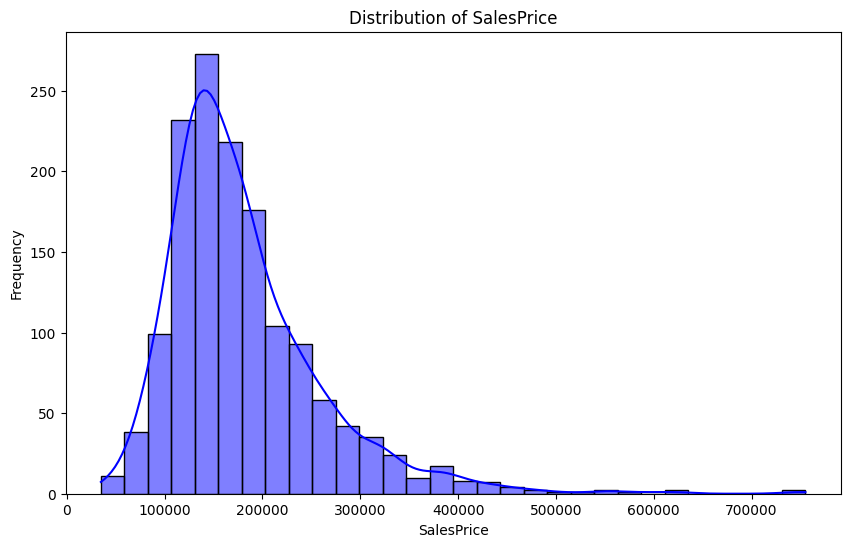

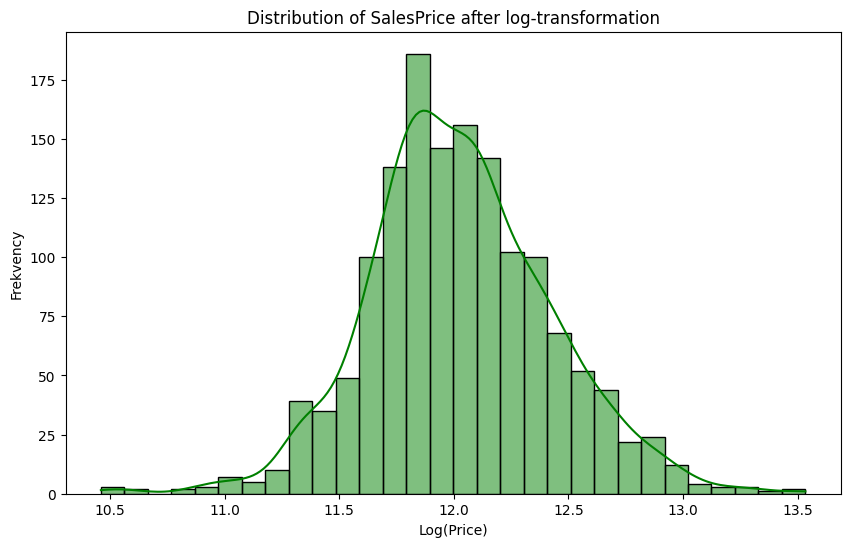

In [348]:
# First plot: Distribution of SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(y_train['SalePrice'], kde=True, bins=30, color='blue')
plt.title('Distribution of SalesPrice')
plt.xlabel('SalesPrice')
plt.ylabel('Frequency')
plt.show()

# Log transform the prices
y_transformed = np.log(y_train['SalePrice'] + 1) # Add 1 to avoid log(0)

# Second plot: Distribution of log-transformed SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(y_transformed, kde=True, bins=30, color='green')
plt.title('Distribution of SalesPrice after log-transformation')
plt.xlabel('Log(Price)')
plt.ylabel('Frekvency')
plt.show()

In [349]:
# Get column types
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

#print("Numerical columns:", numerical_cols)
#print("Categorical columns:", categorical_cols)

In [350]:
#Missing Values in these columns means that there is no available, not missing value --> replace NaN value by 'NA'

cat_cols_missing_by_NA = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']
train_data[cat_cols_missing_by_NA] = train_data[cat_cols_missing_by_NA].fillna('NA')
test_data[cat_cols_missing_by_NA] = test_data[cat_cols_missing_by_NA].fillna('NA')


# CATEGORICAL COLUMNS

## Show distribution of values

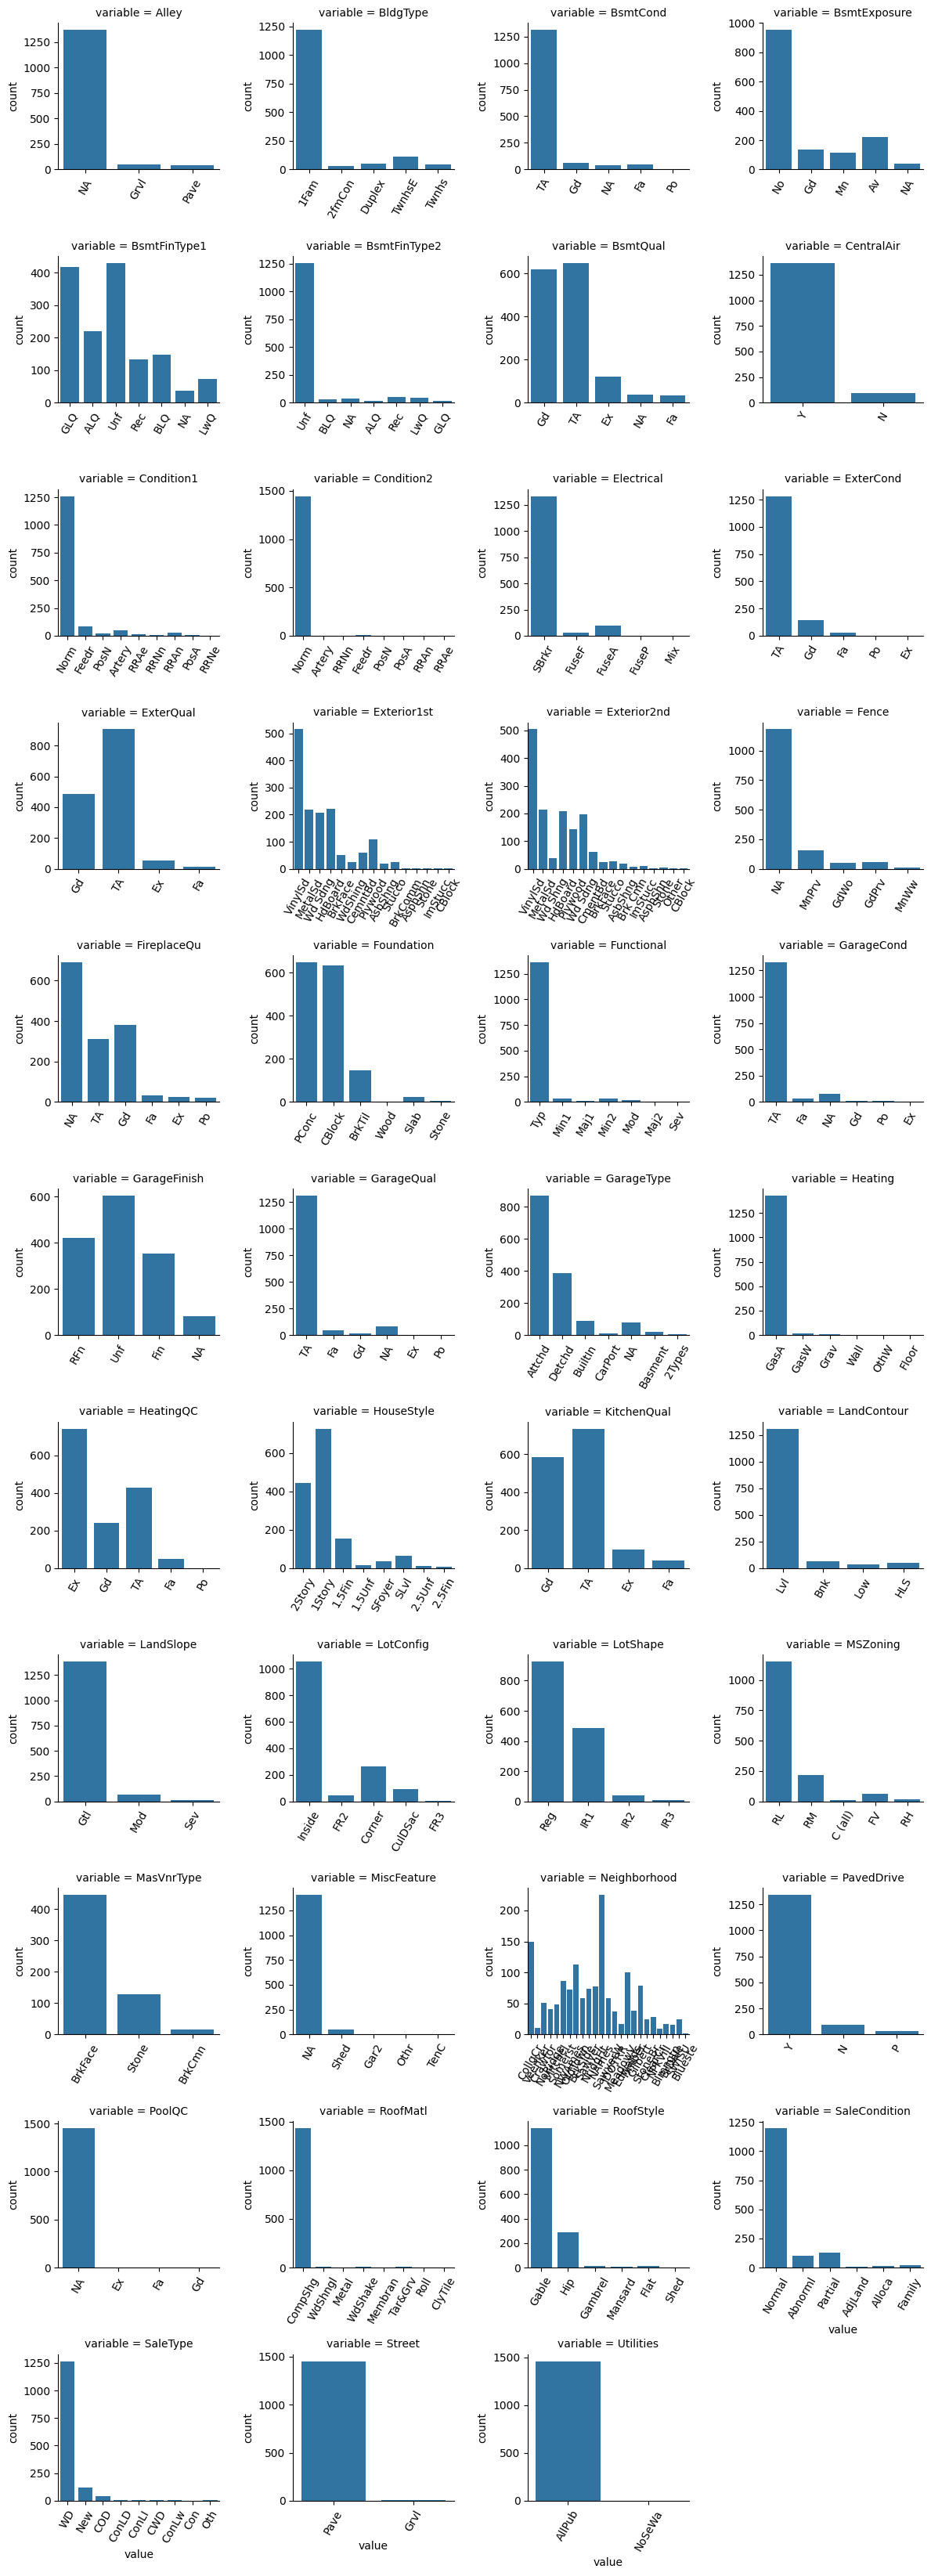

In [351]:
# Count plots of categorical features
f = pd.melt(train_data, value_vars=sorted(categorical_cols))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
plt.xticks(rotation='vertical')
g = g.map(sns.countplot, 'value')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]
g.fig.tight_layout()
plt.show()

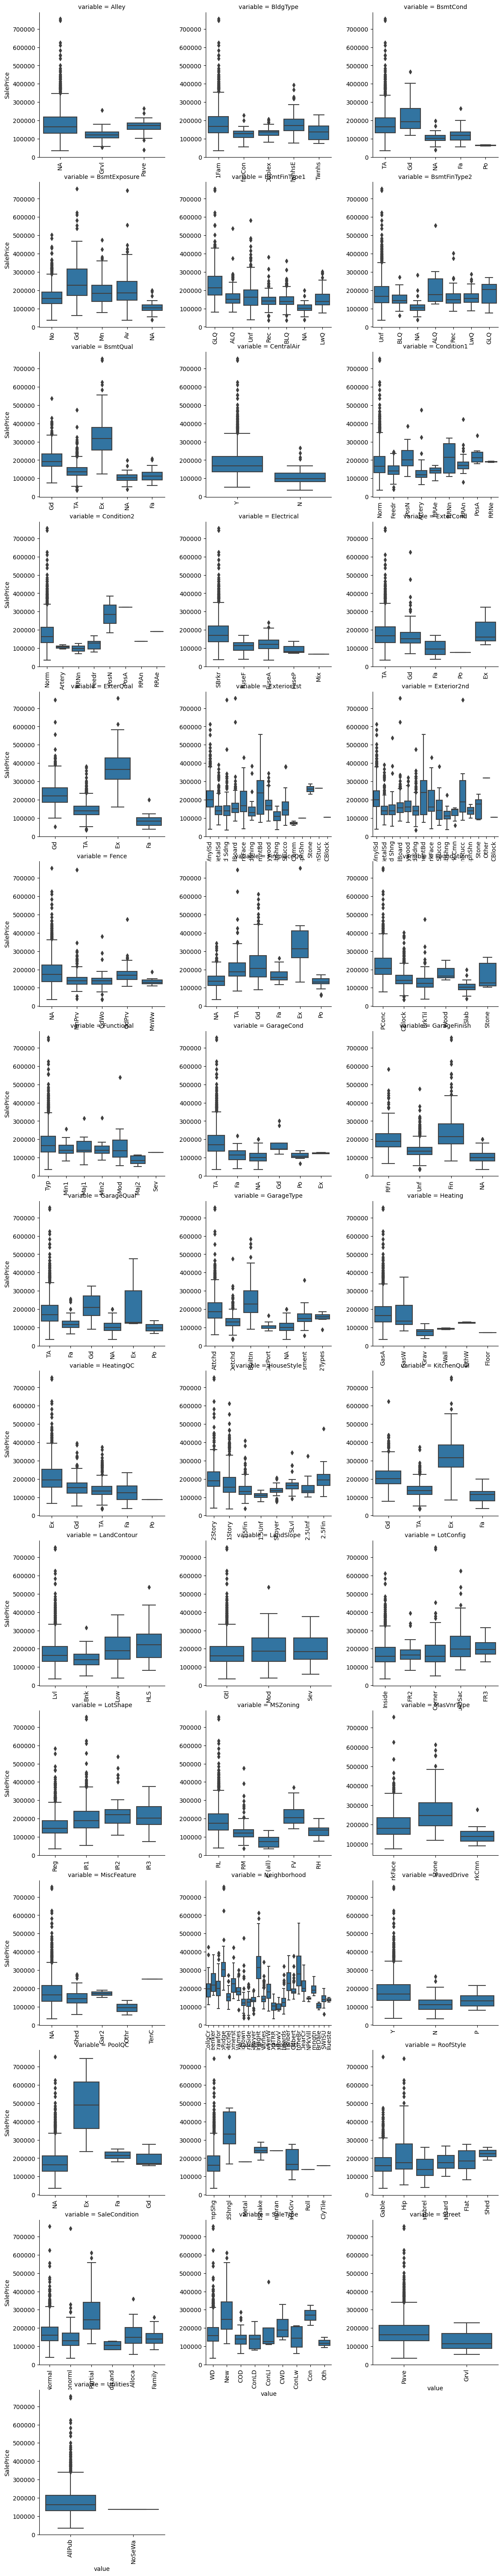

In [352]:
# Assuming train_data and categorical_cols are already defined
f = pd.melt(train_data, id_vars=['SalePrice'], value_vars=sorted(categorical_cols))

# Fix: Use 'height' instead of 'size'
g = sns.FacetGrid(f, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
g = g.map(sns.boxplot, 'value', 'SalePrice')

# Rotate the x-tick labels
[plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]

plt.show()

## DROP IRRELEVANT COLUMNS

In [353]:
# Check if all unique values in categorical columns in test_data are also in train_data
# (if any values are missing, the corresponding columns will be dropped)

columns_to_check = categorical_cols.copy()
columns_missing_values = []

# Compare unique values for each column
for col in columns_to_check:
    unique_train = set(train_data[col].dropna().unique())  # Unique values in train_data (excluding NaN)
    unique_test = set(test_data[col].dropna().unique())  # Unique values in test_data (excluding NaN)
    
    if not unique_test.issubset(unique_train):  # If test_data has values missing in train_data
        columns_missing_values.append(col)

# Print columns that do not meet the condition
print(f"Columns in train_data that do not contain all unique values from test_data:", columns_missing_values)

Columns in train_data that do not contain all unique values from test_data: []


In [354]:
# Identify columns with high missing values ratio

cat_cols_high_missing_ratio = []
for col in categorical_cols:
    # If it contains a lot of missing values, we recommend dropping it
    missing_ratio = train_data[col].isnull().mean()
    if missing_ratio > 0.4:
        cat_cols_high_missing_ratio.append(col)

print(f"Columns that contains more than 40% missing values:", cat_cols_high_missing_ratio)

Columns that contains more than 40% missing values: ['MasVnrType']


In [355]:
# Identify columns with less than 2 unique values

cat_cols_few_unique_values = []
for col in categorical_cols:
    unique_values = train_data[col].nunique()
        
    # Check the number of unique values
    if unique_values < 2:
        cat_cols_few_unique_values.append(col)

print(f"Columns that contains less than 2 unique not NaN values:", cat_cols_few_unique_values)

Columns that contains less than 2 unique not NaN values: []


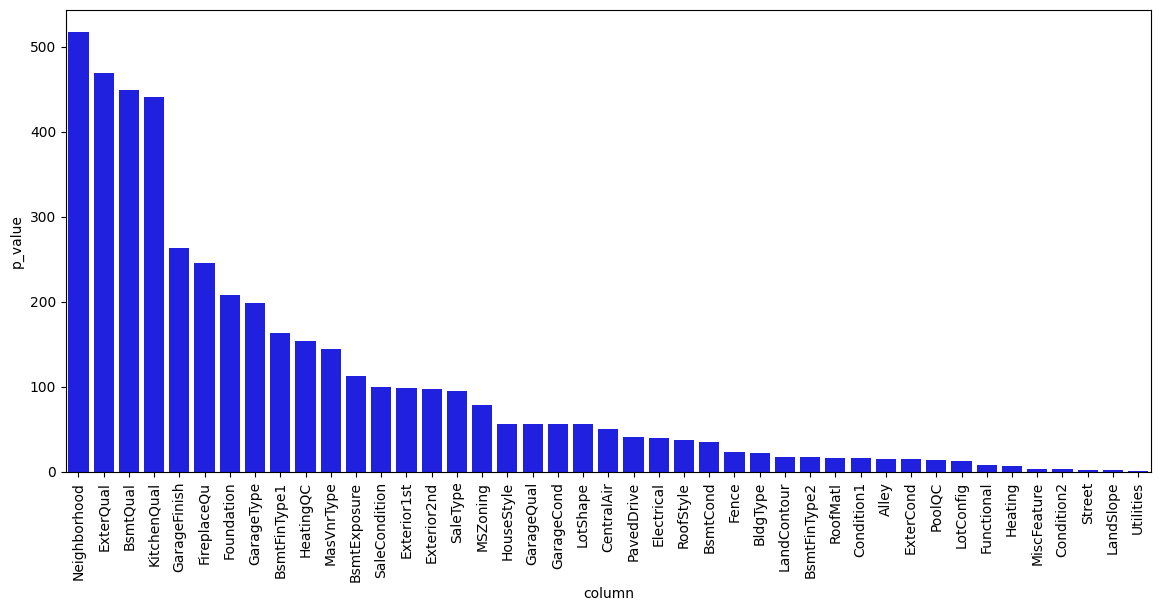

Columns without significant relation: ['Street', 'LandSlope', 'Utilities']


In [356]:
# Target variable
target_column = 'SalePrice'  # Change this to the name of your target column

# Work with categorical columns
categorical_cols = train_data.select_dtypes(include=['object', 'category']).columns

# Output dataframe for decision-making
evaluation_results = []

# Testing categorical columns
for col in categorical_cols:

    # Replace missing values
    train_data[col] = train_data[col].fillna('Missing')

    # For categorical vs numerical target: ANOVA
    if train_data[target_column].dtype in ['float64', 'int64']:

        groups = [train_data[target_column][train_data[col] == val] for val in train_data[col].unique()]
        f_stat, p_value = f_oneway(*groups)
        
        if p_value < 0.05:  # Significant relationship with the target variable
            evaluation_results.append({'column': col, 'reason': 'significant relation (ANOVA)', 'f_stat': f_stat, 'p_value': p_value})
        else:
            evaluation_results.append({'column': col, 'reason': 'no significant relation (ANOVA)', 'f_stat': f_stat, 'p_value': p_value})
    
    # If the target variable is also categorical: Chi-squared test
    #elif train_data[target_column].dtype in ['object', 'category']:
    #    contingency_table = pd.crosstab(train_data[col], train_data[target_column])
    #    chi2, p, dof, expected = chi2_contingency(contingency_table)
        
    #    if p < 0.05:  # Significant relationship with the target variable
    #        evaluation_results.append({'column': col, 'decision': 'keep', 'reason': 'significant relation (Chi-squared)'})
    #    else:
    #        evaluation_results.append({'column': col, 'decision': 'drop', 'reason': 'no significant relation (Chi-squared)'})

train_data = train_data.replace('Missing', np.nan)

# Results as a dataframe
results_df = pd.DataFrame(evaluation_results)


results_df.sort_values('p_value', inplace=True)
results_df.reset_index(drop=True, inplace=True)
# Assuming 'results_df' is your DataFrame
plt.figure(figsize=(14,6))

# Fix: Use keyword arguments to specify x and y
sns.barplot(x=results_df['column'], y=np.log(1. / results_df['p_value']), color='blue')

# Rotate the x-tick labels if necessary
plt.xticks(rotation=90)

# Display the plot
plt.show()

cat_cols_no_significant_relation = results_df[results_df['reason'] == 'no significant relation (ANOVA)']['column'].unique().tolist()
# Display decisions
print(f"Columns without significant relation:", cat_cols_no_significant_relation)

In [357]:
threshold = 0.95  # Set the threshold for dominance (e.g., 95%)

cat_cols_high_dominance = []
# Identify columns where one value dominates
for col in train_data.columns:
    dominant_ratio = train_data[col].value_counts(normalize=True).max()
    if dominant_ratio > threshold and col not in cat_cols_high_dominance:
        cat_cols_high_dominance.append(col)

# Display the results
print(f"Columns that have value with dominance more that 95%:", cat_cols_high_dominance)

Columns that have value with dominance more that 95%: ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating', 'LowQualFinSF', 'KitchenAbvGr', '3SsnPorch', 'PoolArea', 'PoolQC', 'MiscFeature', 'MiscVal']


In [358]:
categorical_cols = [
    col for col in categorical_cols
    if col not in cat_cols_few_unique_values
    and col not in cat_cols_high_missing_ratio
    and col not in cat_cols_high_dominance
    and col not in cat_cols_no_significant_relation
    and col not in cat_cols_high_dominance
]
# Display the updated list of categorical columns
print("Updated categorical columns:", categorical_cols)

Updated categorical columns: ['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition']


## ORDINAL ENCODING 

In [360]:
# Dictionary to define all categorical feature mappings for ordinal encoding
replacement_dicts = {
    'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},  # Excellent, Good, etc.
    'PoolQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},     # Excellent, Good, etc.
    'CentralAir': {'Y': 1, 'N': 0},  # Yes, No
    'PavedDrive': {'Y': 2, 'P': 1, 'N': 0},  # Paved, Partial, Dirt/Gravel
    'BsmtExposure': {'Gd': 5, 'Av': 4, 'Mn': 3, 'No': 2, 'NA': 0},  # Good, Average, etc.
    'BsmtFinType1': {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 0, 'Unf': 0, 'NA': 0},
    'BsmtFinType2': {'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 0, 'Unf': 0, 'NA': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0},  # Finished, Refined, Unfinished
    'Alley': {'Pave': 2, 'Grvl': 1, 'NA': 0},  # Paved, Gravel, No Alley
    'LotShape': {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1},  # Regular, Irregular
    'LandContour': {'Lvl': 4, 'Bnk': 3, 'HLS': 2, 'Low': 1},  # Level, Banked, Hillside, Low
    'Utilities': {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1},  # AllPublic, NoSewer, etc.
    'LandSlope': {'Gtl': 3, 'Mod': 2, 'Sev': 1},  # Gentle, Moderate, Severe Slope
    'Functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},  # Functionality types
}

# Function to apply replacement to the specified columns of the data
def apply_replacement(data, columns, replacement_dicts):
    """
    Apply replacements to the columns based on the provided dictionary mappings.
    """
    for col in columns:
        if col in replacement_dicts:
            data[col] = data[col].replace(replacement_dicts[col])
    return data

# List of categorical columns to be encoded (if not all columns are required, customize this list)
categorical_cols_for_OrdinalEncoding = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual',
    'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC', 'CentralAir', 'PavedDrive',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageFinish', 'Alley', 'LotShape',
    'LandContour', 'Utilities', 'LandSlope', 'Functional'
]

# Apply the replacements for both train and test datasets
train_data = apply_replacement(train_data, categorical_cols_for_OrdinalEncoding, replacement_dicts)
test_data = apply_replacement(test_data, categorical_cols_for_OrdinalEncoding, replacement_dicts)


## ONE HOT ENCODING

In [361]:
# List of columns for One-Hot Encoding
categorical_cols_for_OHEncoding = ['MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 
                                   'RoofStyle', 'Exterior1st', 'Exterior2nd', 'Foundation', 'Electrical', 'GarageType', 
                                   'Fence', 'SaleType', 'SaleCondition']

# One-Hot Encoding
onehot_encoder = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)

# Transforming the training and test data using the same encoder
onehot_encoded_train_data = onehot_encoder.fit_transform(train_data[categorical_cols_for_OHEncoding])
onehot_encoded_test_data = onehot_encoder.transform(test_data[categorical_cols_for_OHEncoding])

# Creating DataFrame for the encoded columns
onehot_encoded_train_data = pd.DataFrame(onehot_encoded_train_data, columns=onehot_encoder.get_feature_names_out(categorical_cols_for_OHEncoding))
onehot_encoded_test_data = pd.DataFrame(onehot_encoded_test_data, columns=onehot_encoder.get_feature_names_out(categorical_cols_for_OHEncoding))

# Checking the results by combining the encoded columns with the original data
train_data = pd.concat([train_data[numerical_cols], train_data[categorical_cols_for_OrdinalEncoding], onehot_encoded_train_data], axis=1)
test_data = pd.concat([test_data[numerical_cols], test_data[categorical_cols_for_OrdinalEncoding], onehot_encoded_train_data], axis=1)

# NUMERICAL COLUMNS

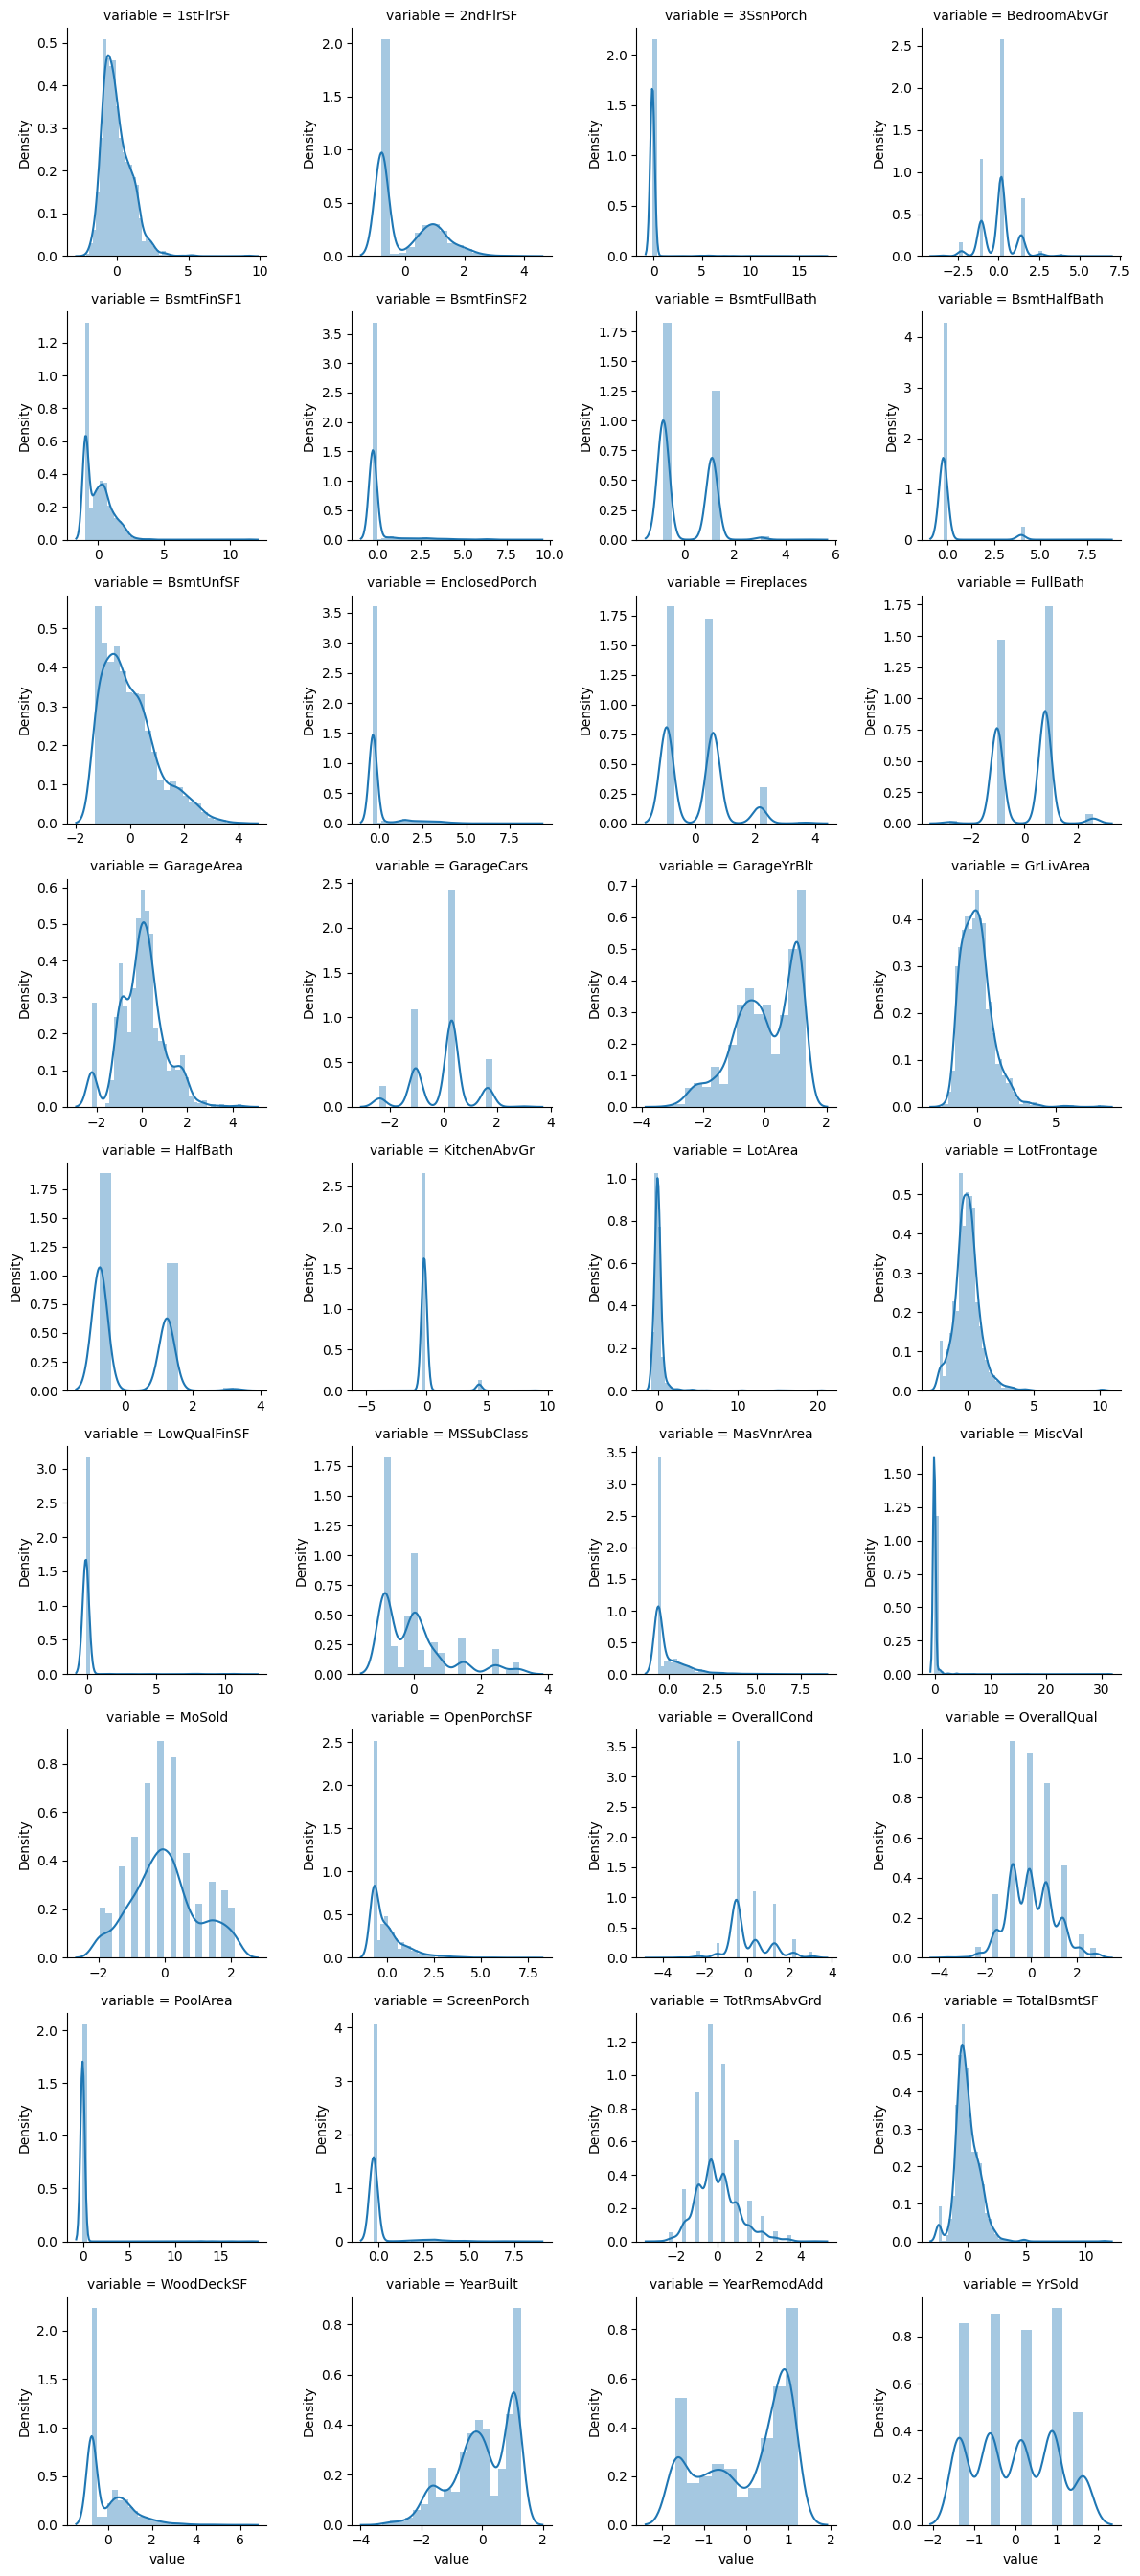

In [362]:
# Grid of distribution plots of all numerical features
f = pd.melt(train_data_inputed, value_vars=sorted(numerical_cols))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
dtype: float64


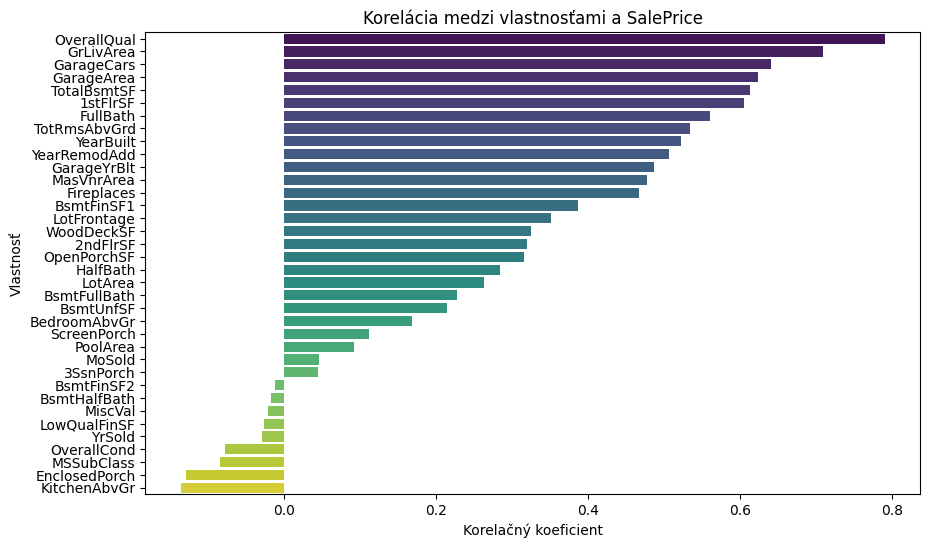

In [363]:
# Výpočet korelácie pre každú numerickú vlastnosť s y
correlations = train_data[numerical_cols].corrwith(y_train['SalePrice'])

# Zoradenie výsledkov podľa hodnoty
correlations = correlations.sort_values(ascending=False)
print(correlations)

# Vykreslenie pruhového grafu
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette="viridis")
plt.title("Korelácia medzi vlastnosťami a SalePrice")
plt.xlabel("Korelačný koeficient")
plt.ylabel("Vlastnosť")
plt.show()

Silná korelácia medzi YearBuilt a GarageYrBlt: 0.83
Silná korelácia medzi TotalBsmtSF a 1stFlrSF: 0.82
Silná korelácia medzi GrLivArea a TotRmsAbvGrd: 0.83
Silná korelácia medzi GarageCars a GarageArea: 0.88


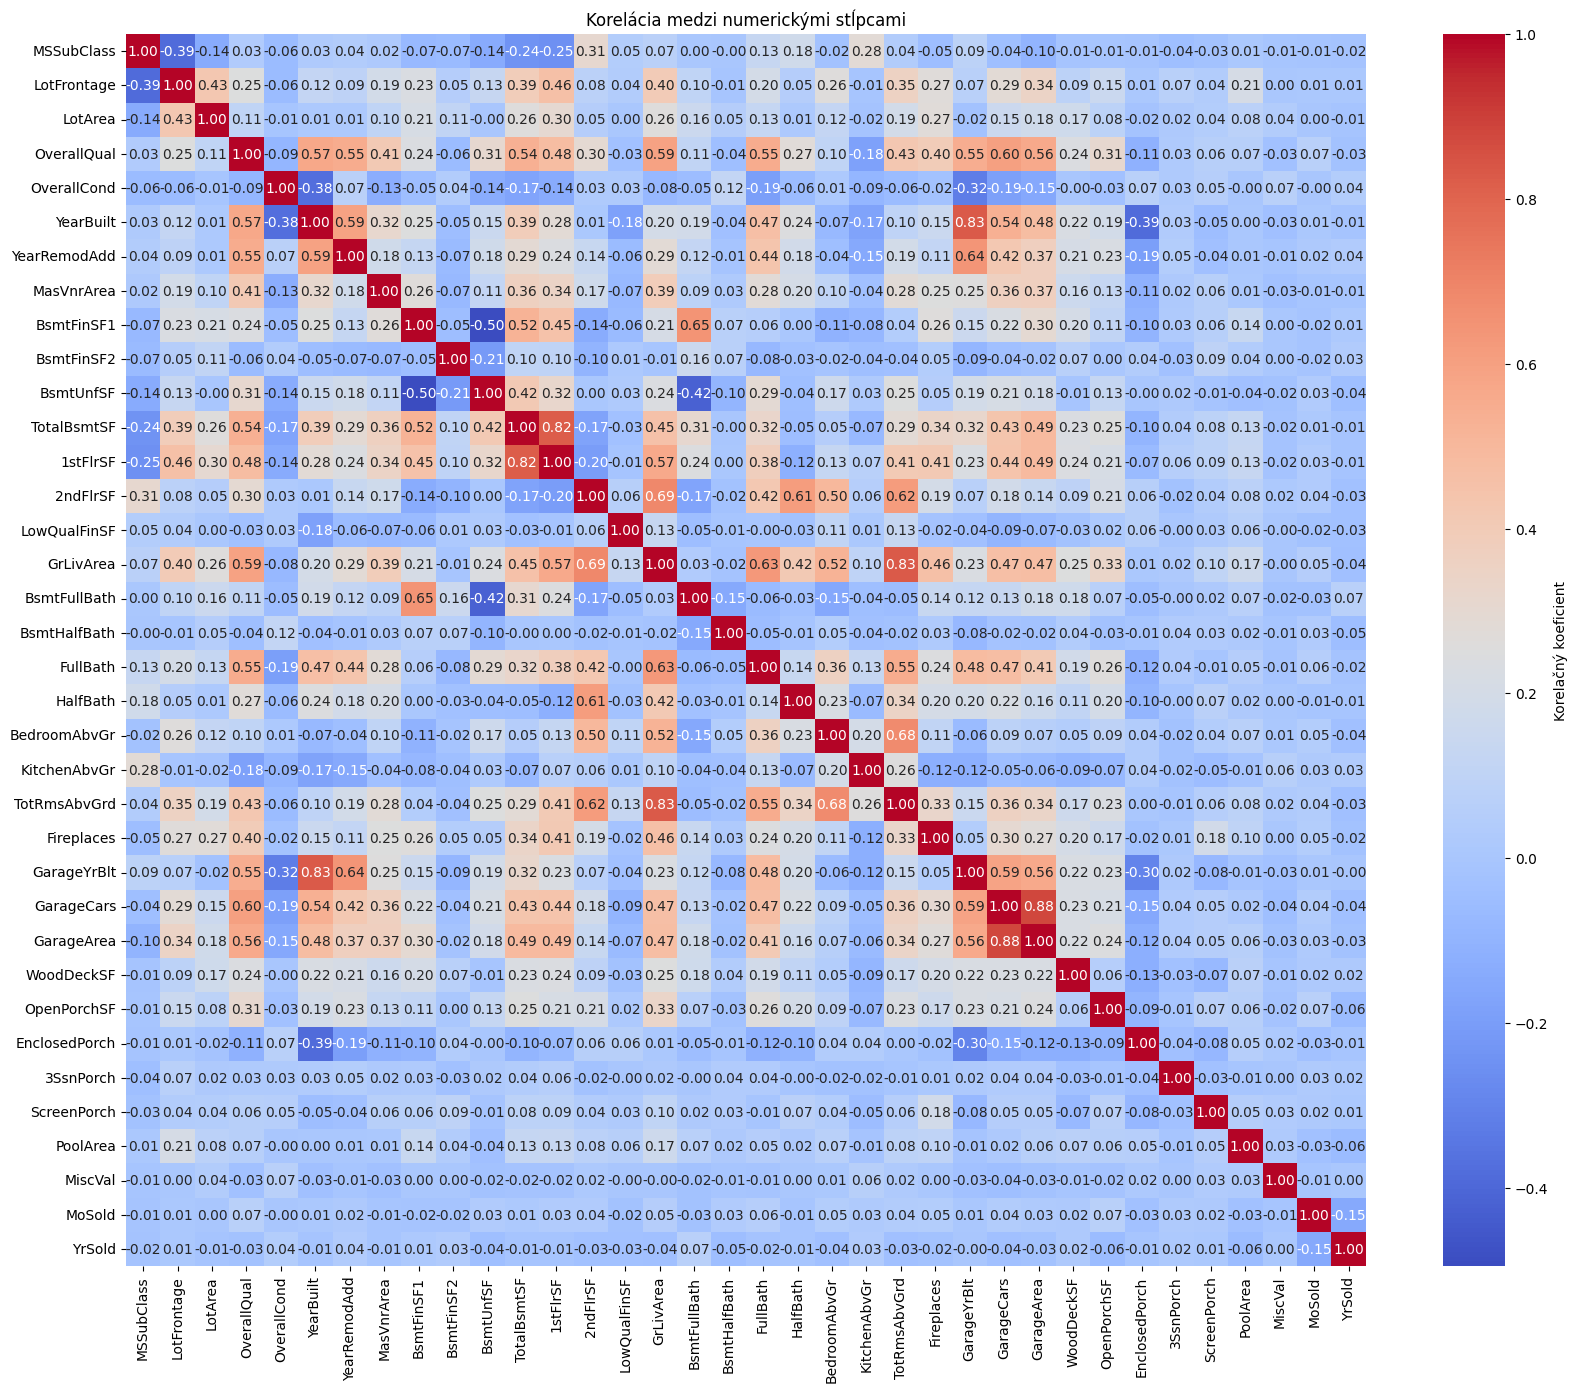

In [364]:

# Vypočítaj korelačnú maticu
correlation_matrix = train_data[numerical_cols].corr()

# Nastav prahovú hodnotu korelácie, napríklad 0.8 pre silné korelácie
threshold = 0.8

# Nahradíme všetky hodnoty nižšie než threshold hodnotou NaN
strong_correlation_matrix = correlation_matrix.applymap(lambda x: x if abs(x) >= threshold else np.nan)

# Nastavenie diagonály na NaN, aby sme odstránili korelácie medzi stĺpcami samými so sebou
np.fill_diagonal(strong_correlation_matrix.values, np.nan)

# Odstránime riadky a stĺpce, ktoré obsahujú iba NaN hodnoty
strong_correlation_matrix_clean = strong_correlation_matrix.dropna(how='all', axis=0)  # Odstrániť riadky s NaN
strong_correlation_matrix_clean = strong_correlation_matrix_clean.dropna(how='all', axis=1)  # Odstrániť stĺpce s NaN

# Zobrazenie výslednej matice so silnými koreláciami
#print(strong_correlation_matrix_clean)

# Vytvoríme cyklus, ktorý prejde cez korelácie a zabezpečí unikátne dvojice
for col1 in range(len(strong_correlation_matrix_clean.columns)):
    for col2 in range(col1+1, len(strong_correlation_matrix_clean.columns)):
        # Získame názvy stĺpcov
        col1_name = strong_correlation_matrix_clean.columns[col1]
        col2_name = strong_correlation_matrix_clean.columns[col2]
        
        # Skontroluj, či je korelácia väčšia než prahová hodnota
        correlation_value = strong_correlation_matrix_clean.loc[col2_name, col1_name]
        if abs(correlation_value) >= threshold and not np.isnan(correlation_value):
            # Vytlač dvojice stĺpcov a ich koreláciu
            print(f"Silná korelácia medzi {col1_name} a {col2_name}: {correlation_value:.2f}")
            
# Vykreslenie heatmapy korelačnej matice
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar_kws={'label': 'Korelačný koeficient'})
plt.title("Korelácia medzi numerickými stĺpcami")
plt.show()

## REPLACING OF MISSING VALUES WITH KNN

In [365]:
# Initialize the KNN imputer (e.g., with 5 nearest neighbors)
knn_imputer = KNNImputer(n_neighbors=5)

# Apply the imputer to the entire DataFrame (including numerical and encoded columns)
train_data_imputed = pd.DataFrame(knn_imputer.fit_transform(train_data), columns=train_data.columns)
test_data_imputed = pd.DataFrame(knn_imputer.fit_transform(test_data), columns=train_data.columns)

## STANDARDIZING 

In [366]:
# Common columns for standardization
cols_to_standardize = list(numerical_cols) + categorical_cols_for_OrdinalEncoding
#cols_to_standardize = list(set(numerical_cols + categorical_cols_for_OrdinalEncoding))

# Initialize the scaler
scaler = StandardScaler()

# Apply standardization only to numerical and ordinal columns
train_data_imputed[cols_to_standardize] = scaler.fit_transform(train_data_imputed[cols_to_standardize])
test_data_imputed[cols_to_standardize] = scaler.transform(test_data_imputed[cols_to_standardize])

In [367]:
train_data_inputed

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-1.730865,0.073375,-0.249697,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.507566,0.575425,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-1.728492,-0.872563,0.382411,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.575352,1.171992,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-1.726120,0.073375,-0.123276,0.073480,0.651479,-0.517200,0.984752,0.830215,0.319713,0.092907,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-1.723747,0.309859,-0.460400,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.575352,-0.499274,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-1.721374,0.073375,0.550973,0.375148,1.374795,-0.517200,0.951632,0.733308,1.358429,0.463568,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.721374,0.073375,-0.376119,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.575352,-0.973018,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1456,1.723747,-0.872563,0.593114,0.266407,-0.071836,0.381743,0.222975,0.151865,0.082134,0.759659,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1457,1.726120,0.309859,-0.207557,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.575352,-0.369871,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1458,1.728492,-0.872563,-0.123276,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.575352,-0.865548,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## MUTUAL INFORMATION

In [368]:
# Vypočítať mutual information medzi vstupnými stĺpcami a cieľovou premennou
mi = mutual_info_classif(train_data_inputed, y_train)

# Vytvoríme DataFrame pre zobrazenie názvov stĺpcov a ich MI hodnoty
mi_df = pd.DataFrame({
    'Feature': train_data_inputed.columns,  # Názvy stĺpcov
    'Mutual Information': mi  # Hodnoty mutual information
})

# Zobraziť DataFrame
print(mi_df)

                   Feature  Mutual Information
0                       Id            0.000000
1               MSSubClass            0.293817
2              LotFrontage            0.110351
3                  LotArea            0.136817
4              OverallQual            0.977643
..                     ...                 ...
172  SaleCondition_AdjLand            0.000000
173   SaleCondition_Alloca            0.000000
174   SaleCondition_Family            0.027165
175   SaleCondition_Normal            2.381381
176  SaleCondition_Partial            0.000000

[177 rows x 2 columns]


In [ ]:
print(sorted(mi_df, )

In [ ]:
# Set up code checking
from learntools.core import binder
binder.bind(globals())
from learntools.machine_learning.ex7 import *

# Set up filepaths
import os
if not os.path.exists("../input/train.csv"):
    os.symlink("../input/home-data-for-ml-course/train.csv", "../input/train.csv")  
    os.symlink("../input/home-data-for-ml-course/test.csv", "../input/test.csv") 

Here's some of the code you've written so far. Start by running it again.

In [ ]:
# Import helpful libraries
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Load the data, and separate the target
iowa_file_path = '../input/train.csv'
home_data = pd.read_csv(iowa_file_path)
y = home_data.SalePrice

# Create X (After completing the exercise, you can return to modify this line!)
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']

# Select columns corresponding to features, and preview the data
X = home_data[features]
X.head()

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

# Define a random forest model
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)
rf_val_mae = mean_absolute_error(rf_val_predictions, val_y)

print("Validation MAE for Random Forest Model: {:,.0f}".format(rf_val_mae))

# Train a model for the competition

The code cell above trains a Random Forest model on **`train_X`** and **`train_y`**.  

Use the code cell below to build a Random Forest model and train it on all of **`X`** and **`y`**.

In [ ]:
iowa_file_path = '../input/train.csv'
home_data = pd.read_csv(iowa_file_path)
y = home_data.SalePrice

# Create X (After completing the exercise, you can return to modify this line!)
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']

# Select columns corresponding to features, and preview the data
X = home_data[features]

In [ ]:
# To improve accuracy, create a new Random Forest model which you will train on all training data
rf_model_on_full_data = RandomForestRegressor(random_state=1)

# fit rf_model_on_full_data on all data from the training data
rf_model_on_full_data.fit(X, y)

Now, read the file of "test" data, and apply your model to make predictions.

In [ ]:
# path to file you will use for predictions
test_data_path = '../input/test.csv'

# read test data file using pandas
test_data = pd.read_csv(test_data_path)

# create test_X which comes from test_data but includes only the columns you used for prediction.
# The list of columns is stored in a variable called features
test_X = test_data[['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']]

# make predictions which we will submit. 
test_preds = rf_model_on_full_data.predict(test_X)

Before submitting, run a check to make sure your `test_preds` have the right format.

In [ ]:
# Check your answer (To get credit for completing the exercise, you must get a "Correct" result!)
step_1.check()
# step_1.solution()

# Generate a submission

Run the code cell below to generate a CSV file with your predictions that you can use to submit to the competition.

In [ ]:
# Run the code to save predictions in the format used for competition scoring

output = pd.DataFrame({'Id': test_data.Id,
                       'SalePrice': test_preds})
output.to_csv('submission.csv', index=False)

# Submit to the competition

To test your results, you'll need to join the competition (if you haven't already).  So open a new window by clicking on **[this link](https://www.kaggle.com/c/home-data-for-ml-course)**.  Then click on the **Join Competition** button.

![join competition image](https://storage.googleapis.com/kaggle-media/learn/images/axBzctl.png)

Next, follow the instructions below:
1. Begin by clicking on the **Save Version** button in the top right corner of the window.  This will generate a pop-up window.  
2. Ensure that the **Save and Run All** option is selected, and then click on the **Save** button.
3. This generates a window in the bottom left corner of the notebook.  After it has finished running, click on the number to the right of the **Save Version** button.  This pulls up a list of versions on the right of the screen.  Click on the ellipsis **(...)** to the right of the most recent version, and select **Open in Viewer**.  This brings you into view mode of the same page. You will need to scroll down to get back to these instructions.
4. Click on the **Data** tab near the top of the screen.  Then, click on the file you would like to submit, and click on the **Submit** button to submit your results to the leaderboard.

You have now successfully submitted to the competition!

If you want to keep working to improve your performance, select the **Edit** button in the top right of the screen. Then you can change your code and repeat the process. There's a lot of room to improve, and you will climb up the leaderboard as you work.


# Continue Your Progress
There are many ways to improve your model, and **experimenting is a great way to learn at this point.**

The best way to improve your model is to add features.  To add more features to the data, revisit the first code cell, and change this line of code to include more column names:
```python
features = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
```

Some features will cause errors because of issues like missing values or non-numeric data types.  Here is a complete list of potential columns that you might like to use, and that won't throw errors:
- 'MSSubClass'
- 'LotArea'
- 'OverallQual' 
- 'OverallCond' 
- 'YearBuilt'
- 'YearRemodAdd' 
- '1stFlrSF'
- '2ndFlrSF' 
- 'LowQualFinSF' 
- 'GrLivArea'
- 'FullBath'
- 'HalfBath'
- 'BedroomAbvGr' 
- 'KitchenAbvGr' 
- 'TotRmsAbvGrd' 
- 'Fireplaces' 
- 'WoodDeckSF' 
- 'OpenPorchSF'
- 'EnclosedPorch' 
- '3SsnPorch' 
- 'ScreenPorch' 
- 'PoolArea' 
- 'MiscVal' 
- 'MoSold' 
- 'YrSold'

Look at the list of columns and think about what might affect home prices.  To learn more about each of these features, take a look at the data description on the **[competition page](https://www.kaggle.com/c/home-data-for-ml-course/data)**.

After updating the code cell above that defines the features, re-run all of the code cells to evaluate the model and generate a new submission file.  


# What's next?

As mentioned above, some of the features will throw an error if you try to use them to train your model.  The **[Intermediate Machine Learning](https://www.kaggle.com/learn/intermediate-machine-learning)** course will teach you how to handle these types of features. You will also learn to use **xgboost**, a technique giving even better accuracy than Random Forest.

The **[Pandas](https://kaggle.com/Learn/Pandas)** course will give you the data manipulation skills to quickly go from conceptual idea to implementation in your data science projects. 

You are also ready for the **[Deep Learning](https://kaggle.com/Learn/intro-to-Deep-Learning)** course, where you will build models with better-than-human level performance at computer vision tasks.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/intro-to-machine-learning/discussion) to chat with other learners.*